In [34]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pkg_resources

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.fit import SynchrotronSelfComptonModel, load_gammapy_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label

load_mpl_rc()

# import gammapy classes
from gammapy.modeling.models import SkyModel
from gammapy.modeling import Fit

In [18]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k=1e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the Gammapy SpectralModel
ssc_model = SynchrotronSelfComptonModel(n_e, backend="gammapy")

In [19]:
ssc_model.parameters["z"].value = 0.0308
ssc_model.parameters["delta_D"].value = 18
ssc_model.parameters["t_var"].value = (1 * u.d).to_value("s")
ssc_model.parameters["t_var"].frozen = True
ssc_model.parameters["log10_B"].value = -1.3

In [20]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k,-8.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,0.000e+00,4.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,4.000e+00,8.000e+00,True,False,
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-1.3000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,


In [21]:
ssc_model.spectral_parameters.to_table()


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k,-8.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,0.000e+00,4.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,4.000e+00,8.000e+00,True,False,


In [22]:
ssc_model.emission_region_parameters.to_table()


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str7,float64,str1,int64,float64,float64,bool,bool,str1
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-1.3000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,
spectral,t_var,8.6400e+04,s,0.000e+00,1.000e+01,3.142e+07,True,False,


In [37]:
sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")

systematics_dict = {
    "Fermi": 0.10,
    "GASP": 0.05,
    "GRT": 0.05,
    "MAGIC": 0.30,
    "MITSuME": 0.05,
    "Medicina": 0.05,
    "Metsahovi": 0.05,
    "NewMexicoSkies": 0.05,
    "Noto": 0.05,
    "OAGH": 0.05,
    "OVRO": 0.05,
    "RATAN": 0.05,
    "ROVOR": 0.05,
    "RXTE/PCA": 0.10,
    "SMA": 0.05,
    "Swift/BAT": 0.10,
    "Swift/UVOT": 0.05,
    "Swift/XRT": 0.10,
    "VLBA(BK150)": 0.05,
    "VLBA(BP143)": 0.05,
    "VLBA(MOJAVE)": 0.05,
    "VLBA_core(BP143)": 0.05,
    "VLBA_core(MOJAVE)": 0.05,
    "WIRO": 0.05,
}

# define minimum and maximum energy to be used in the fit
E_min = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
E_max = 100 * u.TeV

datasets = load_gammapy_flux_points(sed_path, E_min, E_max, systematics_dict)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

/Users/irfanwani/personalprojects/astro/venv/lib/python3.10/site-packages/agnpy/data/mwl_seds/Mrk421_2011.ecsv
Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : Fermi
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : GASP
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : GRT
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : FluxPointsDataset
  Name       : MAGIC
  Instrument : 
  Models     : 

Dataset 4: 

  Type       : FluxPointsDataset
  Name       : MITSuME
  Instrument : 
  Models     : 

Dataset 5: 

  Type       : FluxPointsDataset
  Name       : Medicina
  Instrument : 
  Models     : 

Dataset 6: 

  Type       : FluxPointsDataset
  Name       : Metsahovi
  Instrument : 
  Models     : 

Dataset 7: 

  Type       : FluxPointsDataset
  Name       : NewMexicoSkies
  Instrument : 
  Models     : 

Dataset 8: 

  Type       : FluxPointsDataset
  Name   

In [24]:
sky_model = SkyModel(spectral_model=ssc_model, name="Mrk421")
datasets.models = [sky_model]

721.6202494331533 eV
82


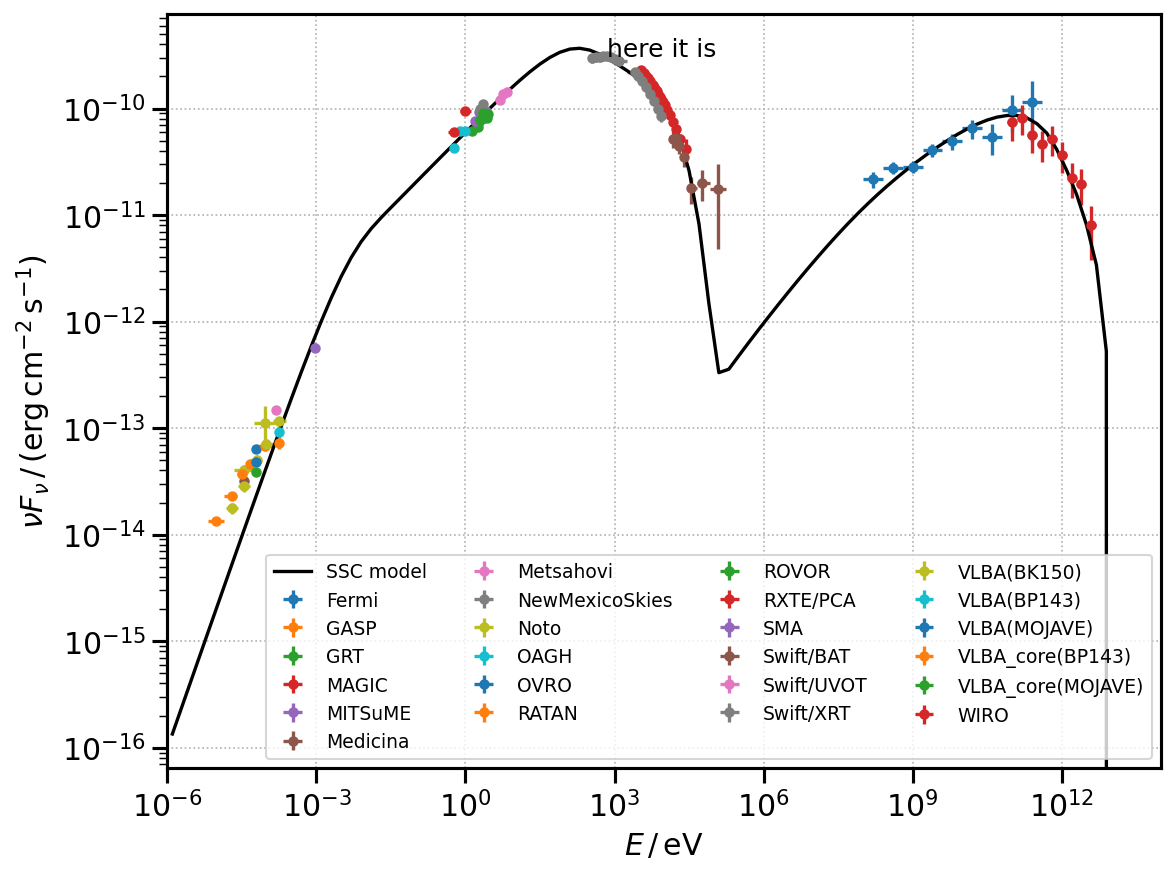

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))

for dataset in datasets:
    dataset.data.plot(ax=ax, label=dataset.name)


xdata = list(np.concatenate([i.get_xdata() for i in ax.get_lines()]))


ydata = [i.get_ydata() for i in ax.get_lines()]

resultdata = list(np.concatenate(ydata))

maxval = max(resultdata)

xval = xdata[resultdata.index(maxval)]
print(xval)
print(resultdata.index(maxval))


ssc_model.plot(
    ax=ax,
    energy_bounds=[1e-6, 1e14] * u.eV,
    energy_power=2,
    label="SSC model",
    color="k",
    lw=1.6,
)

ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.set_xlim([1e-6, 1e14])
ax.legend(ncol=4, fontsize=9)
ax.annotate('here it is', (xval, maxval))

plt.show()

In [26]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)

CPU times: user 1min 30s, sys: 22.6 s, total: 1min 53s
Wall time: 1min 53s


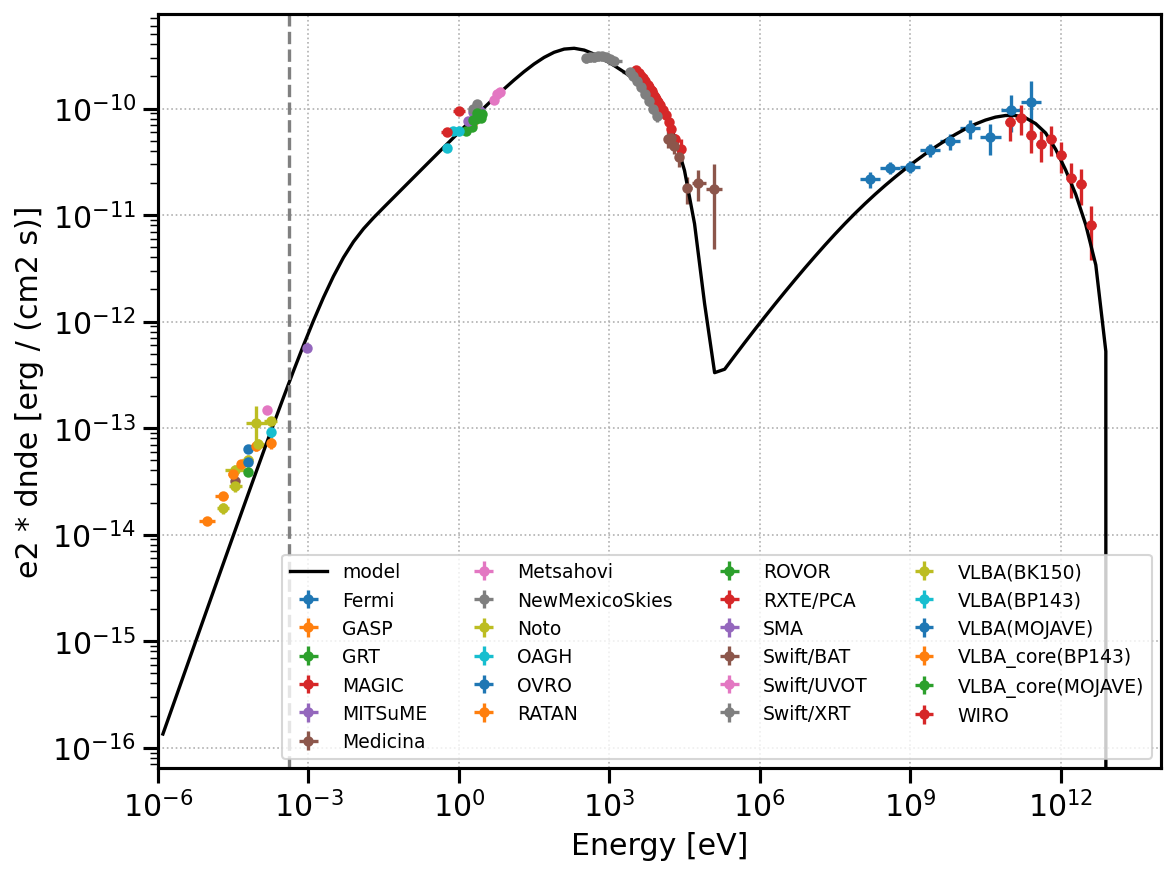

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

for dataset in datasets:
    dataset.data.plot(ax=ax, label=dataset.name)

ssc_model.plot(
    ax=ax,
    energy_bounds=[1e-6, 1e14] * u.eV,
    energy_power=2,
    label="model",
    color="k",
    lw=1.6,
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min, ls="--", color="gray")

plt.legend(ncol=4, fontsize=9)
plt.xlim([1e-6, 1e14])
plt.show()

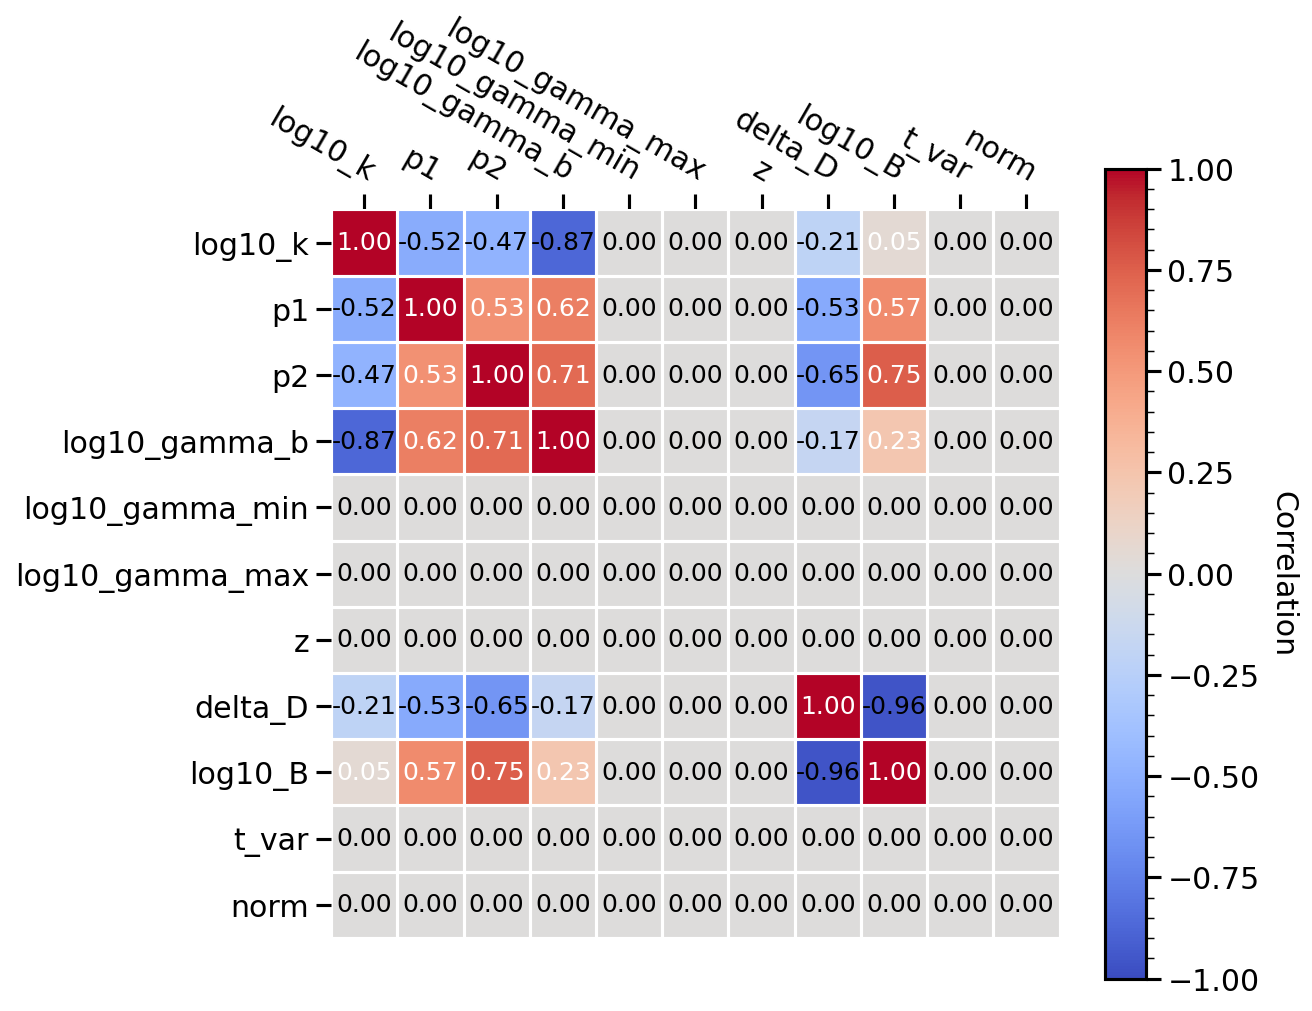

In [28]:
# plot the covariance matrix
ssc_model.covariance.plot_correlation()
plt.grid(False)
plt.show()

log10_k
{'Mrk421.spectral.log10_k_scan': array([-8.02767167, -8.02178961, -8.01590756, -8.0100255 , -8.00414344,
       -7.99826138, -7.99237932, -7.98649726, -7.9806152 , -7.97473314,
       -7.96885108, -7.96296902, -7.95708696, -7.95120491, -7.94532285,
       -7.93944079, -7.93355873, -7.92767667, -7.92179461, -7.91591255,
       -7.91003049, -7.90414843, -7.89826637, -7.89238431, -7.88650225,
       -7.8806202 , -7.87473814, -7.86885608, -7.86297402, -7.85709196,
       -7.8512099 , -7.84532784, -7.83944578, -7.83356372, -7.82768166,
       -7.8217996 , -7.81591755, -7.81003549, -7.80415343, -7.79827137,
       -7.79238931, -7.78650725, -7.78062519, -7.77474313, -7.76886107,
       -7.76297901, -7.75709695, -7.7512149 , -7.74533284, -7.73945078]), 'stat_scan': array([1311.2125914 , 1241.2355282 , 1172.73254368, 1105.79654762,
       1040.52405709,  977.01532897,  915.37449745,  855.70971704,
        798.13331109,  742.76192622,  689.71669279,  639.12339178,
        591.11262825,  

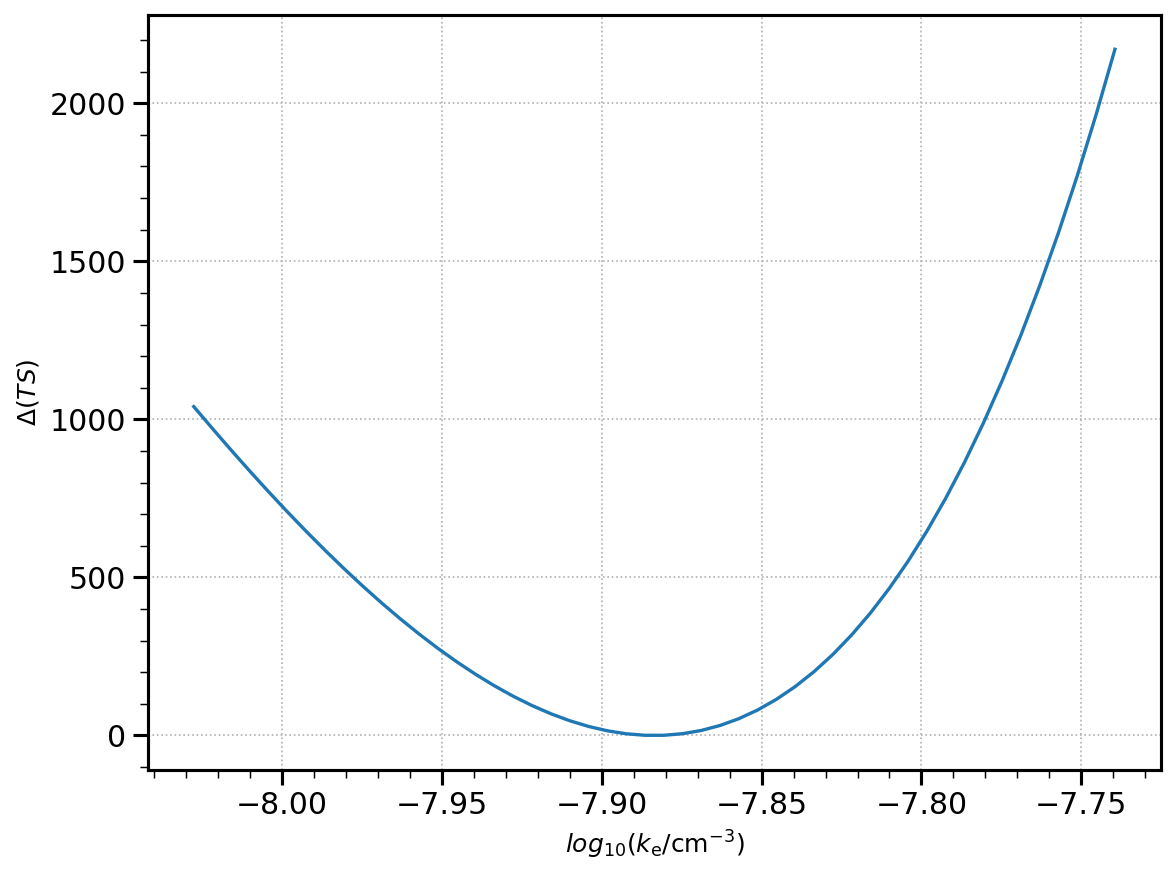

CPU times: user 13.6 s, sys: 3.13 s, total: 16.8 s
Wall time: 16.3 s


In [31]:
%%time
# plot the profile for the normalisation of the electron energy distribution
par = sky_model.spectral_model.log10_k
par.scan_n_values = 50
profile = fitter.stat_profile(datasets=datasets, parameter=par)

print(par.name)

print(profile)

# to compute the delta TS
total_stat = results.total_stat
plt.plot(profile[f"Mrk421.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat) # profile["log10_k_scan"]
plt.ylabel(r"$\Delta(TS)$", size=12)
plt.xlabel(r"$log_{10}(k_{\rm e} / {\rm cm}^{-3})$", size=12)
plt.show()